In [1]:
!pip install numpy scipy networkx

Generating synthetic data

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.linalg import eigh


In [3]:
def generate_time_varying_precision(p=10, N=50, eps=1e-6, soft_lambda=0.14):
    """
    Generate a list of time-varying precision matrices Omega(t),
    following the four steps (i)-(iv) described:

      (i)  B_i are lower-triangular with entries ~ N(0,1/2).
      (ii) G(t) = ( sum_i B_i * phi_i(t) ) / 2.
      (iii) Omega^o(t) = G(t)G(t)^T, then soft-threshold off-diagonals.
      (iv) Add log10(p)/4 to the diagonal for positive definiteness.
    """

    # 1. Generate lower-triangular matrices B1,B2,B3,B4
    #    with elements from Normal(0, 1/2).
    B_list = [np.tril(np.random.normal(0, np.sqrt(0.5), (p, p))) 
              for _ in range(4)]

    # 2. Create time grid from 0 to 1
    t_values = np.linspace(0, 1, N)
    Omega_list = []

    for t in t_values:
        # Define phi_1(t), phi_2(t), phi_3(t), phi_4(t)
        phi = [
            np.sin(np.pi * t / 2),
            np.cos(np.pi * t / 2),
            np.sin(np.pi * t / 4),
            np.cos(np.pi * t / 4)
        ]

        # 3. Compute G(t) = (B1*phi1 + B2*phi2 + B3*phi3 + B4*phi4) / 2
        G = sum(B * ph for B, ph in zip(B_list, phi)) / 2

        # Omega^o(t) = G(t)*G(t)^T
        Omega_o = G @ G.T  # automatically symmetric

        # 4. Soft-threshold off-diagonal elements
        #    off_diag = sign(x) * max(|x|-lambda, 0)
        off_diag = Omega_o - np.diag(np.diag(Omega_o))  # zero out diag
        sign_off = np.sign(off_diag)
        mag_off = np.abs(off_diag)
        off_diag_thresh = sign_off * np.maximum(mag_off - soft_lambda, 0.0)

        # Put thresholded off-diagonals back, keep original diagonal
        Omega = np.diag(np.diag(Omega_o)) + off_diag_thresh

        # 5. Add log10(p)/4 to the diagonal to ensure positivity
        diag_adj = np.log10(p)/4 + eps
        Omega += np.eye(p) * diag_adj

        # 6. Double-check positive definiteness (just in case)
        eigvals, _ = eigh(Omega)
        if np.any(eigvals <= 0):
            # If not PD, shift up by |min_eig| + eps
            Omega += np.eye(p) * (abs(np.min(eigvals)) + eps)

        Omega_list.append(Omega)

    return Omega_list

def generate_synthetic_data(p=10, N=50):
    """
    Generate a time-series dataset X(t) by sampling from
    N(0, Sigma(t)), where Sigma(t) = Omega(t)^{-1}.
    The code returns:
      dataset: shape (N, p)
      Omega_list: list of precision matrices for each time grid
    """
    Omega_list = generate_time_varying_precision(p, N)

    dataset = np.zeros((N, p))
    for i, Omega in enumerate(Omega_list):
        # Invert each Omega(t) to get Sigma(t)
        try:
            Sigma = np.linalg.inv(Omega)
        except np.linalg.LinAlgError:
            Sigma = np.linalg.pinv(Omega)

        # Draw a single sample from N(0, Sigma)
        dataset[i] = multivariate_normal.rvs(
            mean=np.zeros(p),
            cov=Sigma,
            size=1
        )

    # Center the entire dataset
    dataset -= dataset.mean(axis=0)
    return dataset, Omega_list


Blockwise ADMM

In [4]:
import numpy as np

def admm_loggle(
    S_dict,            # dict of empirical covariances: i -> \hat{Sigma}(t_i), each p x p
    time_indices,      # list or set of time indices i in Nk,d
    lam,               # penalty weight (omega in your text)
    rho,               # ADMM parameter (> 0), recommended ~ lam
    alpha=1.5,         # over-relaxation parameter
    abs_tol=1e-5,      # absolute tolerance for stopping
    rel_tol=1e-3,      # relative tolerance for stopping
    max_iter=1000,     # maximum ADMM iterations
    verbose=False
):
    """
    Solve the local group-lasso problem via ADMM for the set of time points in `time_indices`,
    i.e. Nk,d = { i : |t_i - t_k| <= d }.

    The objective is
       min_{Omega,Z} sum_{i in Nk,d} [ tr(Omega(t_i) * S(t_i)) - log det(Omega(t_i)) ]
                     + lam * sum_{u!=v} sqrt( sum_{i in Nk,d} Z_uv(t_i)^2 ),
    subject to Omega(t_i) - Z(t_i) = 0, Omega(t_i) >> 0, i in Nk,d.

    Returns dictionaries:
       Omega_dict, Z_dict, U_dict
    containing the final ADMM iterates for each time index.

    References:
    - The "loggle" step (i)-(iii) from your question.
    - Over-relaxation from Boyd et al. (2011) "Distributed Optimization and Statistical Learning via ADMM", Sec. 3.4.3.
    """

    # ---- 1) Initialization ----------------------------------
    # We'll store the ADMM iterates in dictionaries keyed by i in time_indices.
    # For convenience, let p be the dimension from the shape of any S(t_i).
    i0 = time_indices[0]
    p = S_dict[i0].shape[0]

    # Initialize Z^(0) and U^(0) to zero
    Z_dict = {i: np.zeros((p,p), dtype=float) for i in time_indices}
    U_dict = {i: np.zeros((p,p), dtype=float) for i in time_indices}
    Omega_dict = {i: np.zeros((p,p), dtype=float) for i in time_indices}  # will be updated

    # For faster updates, pre-compute identity
    I_p = np.eye(p)

    # ---- 2) ADMM loop ----------------------------------------
    for s in range(max_iter):

        # ---- (i) Update Omega^(s)(t_i) for each i in Nk,d ----
        for i in time_indices:
            # M = \hat{Sigma}(t_i) - rho ( Z^{s-1}(t_i) - U^{s-1}(t_i) )
            M = S_dict[i] - rho*(Z_dict[i] - U_dict[i])

            # Eigen-decompose M = Q * Lambda * Q^T
            # Then solve for Omega = Q * diag(omega_j) * Q^T
            # where omega_j = (-lambda_j + sqrt(lambda_j^2 + 4 rho)) / (2 rho).
            eigvals, Q = np.linalg.eigh(M)
            # Build the diagonal of solutions
            new_eigs = np.array([
                (-lmbd + np.sqrt(lmbd**2 + 4.0*rho)) / (2.0*rho)
                for lmbd in eigvals
            ])
            Omega_dict[i] = (Q * new_eigs) @ Q.T  # Q diag(new_eigs) Q^T

        # ---- Over-relaxation: O_bar = alpha*Omega + (1-alpha)*Z ----
        O_bar_dict = {}
        for i in time_indices:
            O_bar_dict[i] = alpha * Omega_dict[i] + (1.0 - alpha) * Z_dict[i]

        # ---- (ii) Update Z^(s)(t_i) for each i in Nk,d --------
        #
        #  - Diagonal: Z_{uu}(t_i) = O_bar_{uu}(t_i) + U_{uu}(t_i).
        #  - Off-diagonal: group-lasso across i in Nk,d for each (u,v).
        #    L_{uv} = sqrt( sum_{i} (O_bar_{uv}(t_i) + U_{uv}(t_i))^2 ).
        #    Then Z_{uv}(t_i) = max(1 - lam/(rho * L_{uv}), 0) * (O_bar_{uv}(t_i) + U_{uv}(t_i)).
        #
        # We do it in a vectorized way per (u,v). The group-lasso shrinks each (u,v) across all i simultaneously.
        Z_old = {i: Z_dict[i].copy() for i in time_indices}  # for dual residual

        # For each pair (u,v), gather the set of "O_bar_{uv} + U_{uv}" across i
        # We can do a double loop over u,v or a triple nested loop. 
        # For large p, you might want to vectorize carefully, but here we keep it more explicit.
        for u in range(p):
            for v in range(p):
                # Diagonal case: no shrink
                if u == v:
                    for i in time_indices:
                        Z_dict[i][u,v] = O_bar_dict[i][u,v] + U_dict[i][u,v]
                # Off-diagonal: group-lasso
                else:
                    # Collect the entire vector [ O_bar_{uv}(ti)+U_{uv}(ti) for i in Nk,d ]
                    big_vec = np.array([O_bar_dict[i][u,v] + U_dict[i][u,v] for i in time_indices])
                    norm_val = np.linalg.norm(big_vec, 2)  # L_{uv}

                    if norm_val == 0.0:
                        shrink = 0.0
                    else:
                        shrink = max(0.0, 1.0 - lam/(rho * norm_val))

                    # Update each Z_{uv}(t_i)
                    for idx_i, i in enumerate(time_indices):
                        Z_dict[i][u,v] = shrink * big_vec[idx_i]

        # ---- (iii) Update U^(s)(t_i) for each i in Nk,d -------
        for i in time_indices:
            # Standard ADMM dual update with *no* over-relaxation here
            U_dict[i] = U_dict[i] + (Omega_dict[i] - Z_dict[i])

        # ---- 3) Check stopping criteria (primal and dual residuals) ---
        # primal residual r^s = Omega^s - Z^s, dual residual d^s = Z^s - Z^(s-1)
        r_norm_sq = 0.0
        d_norm_sq = 0.0
        Om_norm_sq = 0.0
        Z_norm_sq = 0.0
        U_norm_sq = 0.0

        for i in time_indices:
            r_ij = Omega_dict[i] - Z_dict[i]
            d_ij = Z_dict[i] - Z_old[i]

            r_norm_sq += np.sum(r_ij**2)
            d_norm_sq += np.sum(d_ij**2)

            Om_norm_sq += np.sum(Omega_dict[i]**2)
            Z_norm_sq += np.sum(Z_dict[i]**2)
            U_norm_sq += np.sum(U_dict[i]**2)

        r_norm = np.sqrt(r_norm_sq)
        d_norm = np.sqrt(d_norm_sq)

        # primal feasibility tolerance
        eps_pri = abs_tol*np.sqrt(p*p*len(time_indices)) + \
                  rel_tol*max(np.sqrt(Om_norm_sq), np.sqrt(Z_norm_sq))

        # dual feasibility tolerance
        eps_dual = abs_tol*np.sqrt(p*p*len(time_indices)) + \
                   rel_tol*np.sqrt(U_norm_sq)

        if verbose and (s % 50 == 0):
            print(f"ADMM iter {s:4d}: r_norm={r_norm:.3e}, d_norm={d_norm:.3e},"
                  f" eps_pri={eps_pri:.3e}, eps_dual={eps_dual:.3e}")

        if (r_norm <= eps_pri) and (d_norm <= eps_dual):
            if verbose:
                print(f"Converged at iteration {s}")
            break

    return Omega_dict, Z_dict, U_dict


Calculating smoothed covariance matrices

In [5]:
# Estimate covariance at all times

def gaussian_kernel(u, normalize=True):
    """
    Standard Gaussian kernel K(u) = exp(-u^2/2) / sqrt(2*pi), if normalize=True.
    If normalize=False, we drop 1/sqrt(2*pi) and just use exp(-u^2/2).
    """
    c = 1.0 / np.sqrt(2.0 * np.pi) if normalize else 1.0
    return c * np.exp(-0.5 * u**2)

def kernel_smoothed_cov(x_data, times, t_target, h, kernel_fun=gaussian_kernel):
    """
    Compute the kernel-smoothed covariance at a single target time t_target.

    Parameters
    ----------
    x_data : numpy array of shape (N, p)
        Observations x_j in R^p. The j-th row is x_j^T.
    times : numpy array of shape (N,)
        Observation times corresponding to each x_j.
    t_target : float
        The target time at which we want \hat{Sigma}(t_target).
    h : float
        Bandwidth for the kernel.
    kernel_fun : callable
        A kernel function K(u), e.g. Gaussian.

    Returns
    -------
    cov_matrix : (p, p) numpy array
        The kernel-smoothed covariance matrix at time t_target.
    """
    N, p = x_data.shape

    # Compute all weights w_j = K((t_j - t_target)/h).
    diffs = (times - t_target) / h
    weights = np.array([kernel_fun(d) for d in diffs])

    # Normalize weights so that they sum to 1.
    w_sum = weights.sum()
    if w_sum <= 1e-14:
        # Edge case: if no points get any weight, return something safe (e.g. zero or unweighted).
        # Or you could just return the empirical covariance unweighted.
        return np.cov(x_data.T, bias=True)

    w_normalized = weights / w_sum

    # Accumulate weighted outer products x_j x_j^T
    cov_matrix = np.zeros((p,p), dtype=float)
    for j in range(N):
        x_j = x_data[j]  # shape (p,)
        cov_matrix += w_normalized[j] * np.outer(x_j, x_j)

    return cov_matrix


In [6]:
def kernel_smoothed_covs_at_observed_times(x_data, times, h, kernel_fun=gaussian_kernel):
    """
    Compute kernel-smoothed covariance at each observed time in 'times'.

    Returns
    -------
    cov_dict : dict
        Keys: i = 0, 1, ..., N-1
        Values: (p,p) numpy arrays, \hat{Sigma}(t_i)
    """
    N = len(times)
    cov_dict = {}
    for i, t_i in enumerate(times):
        cov_dict[i] = kernel_smoothed_cov(x_data, times, t_i, h, kernel_fun)
    return cov_dict



In [7]:
#  Generate synthetic data
N = 50   # number of samples (time points)
p = 10   # dimension
times = np.linspace(0, 1, N) 
x_data, true_omega = generate_synthetic_data(p, N)

h = 0.2 # bandwidth
S_dict = kernel_smoothed_covs_at_observed_times(x_data, times, h, kernel_fun=gaussian_kernel)

k = 20  
d = 0.2  # 0.1 means we consider all t_i such that |t_i - t_k| <= 0.1
    

In [8]:
Nk_d = [i for i, tval in enumerate(times) if abs(tval - times[k]) <= d]

In [16]:
Nk_d[2]

13

In [9]:
Omega_sol, Z_sol, U_sol = admm_loggle(
    S_dict=S_dict,
    time_indices=Nk_d,
    lam=0.1,
    rho=0.1,
    alpha=1.5,
    abs_tol=1e-5,
    rel_tol=1e-3,
    max_iter=1000,
    verbose=True
)

ADMM iter    0: r_norm=9.112e+00, d_norm=2.545e+01, eps_pri=2.589e-02, eps_dual=9.547e-03
ADMM iter   50: r_norm=9.487e-01, d_norm=1.887e+00, eps_pri=2.672e-02, eps_dual=9.987e-03
ADMM iter  100: r_norm=3.401e-01, d_norm=6.770e-01, eps_pri=2.665e-02, eps_dual=9.875e-03
ADMM iter  150: r_norm=1.413e-01, d_norm=2.815e-01, eps_pri=2.663e-02, eps_dual=9.848e-03
ADMM iter  200: r_norm=6.237e-02, d_norm=1.242e-01, eps_pri=2.662e-02, eps_dual=9.839e-03
ADMM iter  250: r_norm=2.815e-02, d_norm=5.609e-02, eps_pri=2.662e-02, eps_dual=9.836e-03
ADMM iter  300: r_norm=1.282e-02, d_norm=2.554e-02, eps_pri=2.662e-02, eps_dual=9.835e-03
ADMM iter  350: r_norm=5.858e-03, d_norm=1.167e-02, eps_pri=2.662e-02, eps_dual=9.835e-03
Converged at iteration 361


In [10]:
np.mean(Omega_sol[16])

0.24576605262950096

In [11]:
np.mean(true_omega[16])

0.241058197529144

Mean absolute difference: -0.0767
Max absolute difference: 1.2324


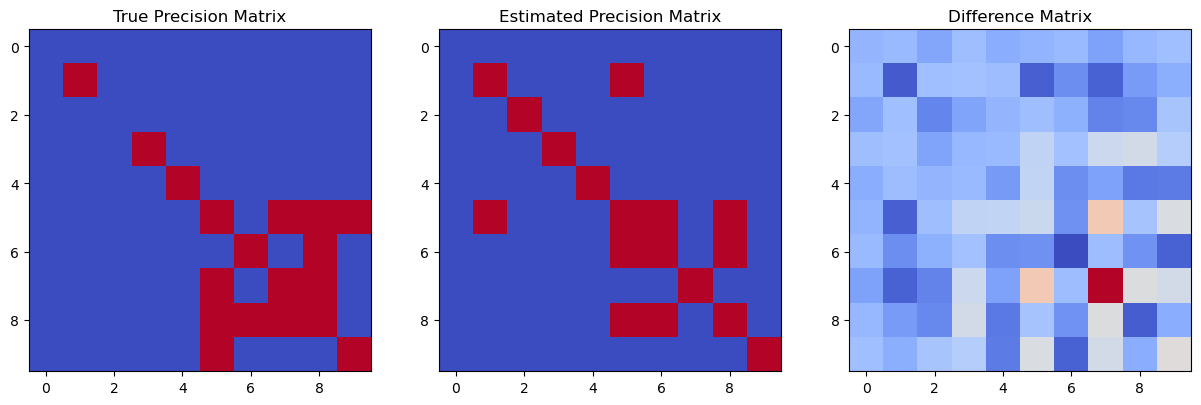

In [12]:
diff = np.abs(true_omega[16]) - np.abs(Omega_sol[16])
print(f"Mean absolute difference: {np.mean(diff):.4f}")
print(f"Max absolute difference: {np.max(diff):.4f}")

# Visualization
import matplotlib.pyplot as plt

gt_edges = (np.abs(true_omega[16]) > 0.5).astype(int)
est_edges = (np.abs(Omega_sol[16]) > 0.5).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gt_edges, cmap='coolwarm', interpolation='none')
axes[0].set_title("True Precision Matrix")

axes[1].imshow(est_edges, cmap='coolwarm', interpolation='none')
axes[1].set_title("Estimated Precision Matrix")

axes[2].imshow(diff, cmap='coolwarm', interpolation='none')
axes[2].set_title("Difference Matrix")

plt.show()


In [13]:
Omega_sol.keys()

dict_keys([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])